In [1]:
from wandb_utils import RunInfo
from datetime import datetime
import pandas as pd

/Users/joschka/mambaforge/envs/kinodata/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runs = RunInfo.fetch(
    since=datetime(2023, 7, 17, 0)
)

In [3]:
df = pd.DataFrame(
    [
        {
            "run": run,
            "split_type": run.split.type,
            "split_fold": run.split.index,
            "rmsd_threshold": run.get("filter_rmsd_max_value"),
            "test/corr": run.run.summary.get("test/corr", None),
            "test/mae": run.run.summary.get("test/mae", None),
            "model": run.model_name
        }
        for run in runs
    ]
).dropna().drop_duplicates(subset = ["split_type", "split_fold", "rmsd_threshold", "model"])

In [4]:
renaming = {
    "GIN": "LGNN",
    "DTI": "DTI",
    "Covalent Transformer": "CGNN",
    "Structural Transformer": "CGNN-3D",
}
df["model"] = df["model"].apply(renaming.get)
df.model

0          DTI
1          DTI
2          DTI
3          DTI
4          DTI
        ...   
210       CGNN
213    CGNN-3D
214    CGNN-3D
215    CGNN-3D
216    CGNN-3D
Name: model, Length: 180, dtype: object

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

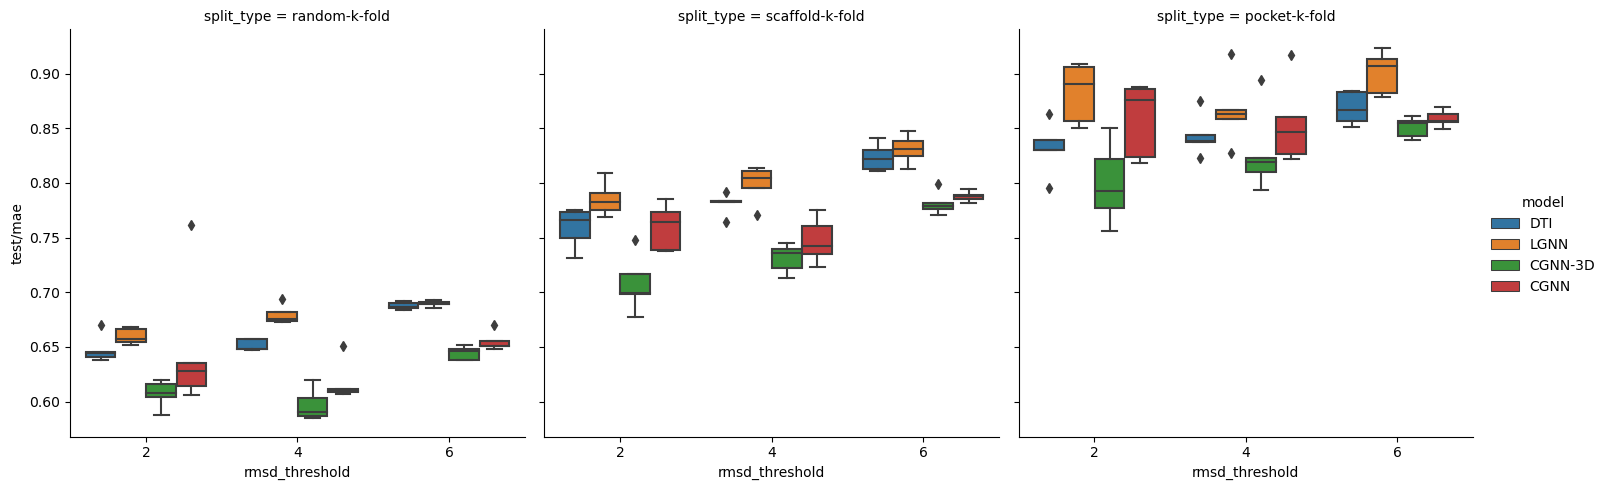

In [6]:
grid = sns.catplot(
    df, x="rmsd_threshold", y="test/mae", hue="model", kind="box",
    #hue_order=["Structural Transformer", "Covalent Transformer"],
    col="split_type",sharey=True,
    col_order=["random-k-fold", "scaffold-k-fold", "pocket-k-fold"]
)

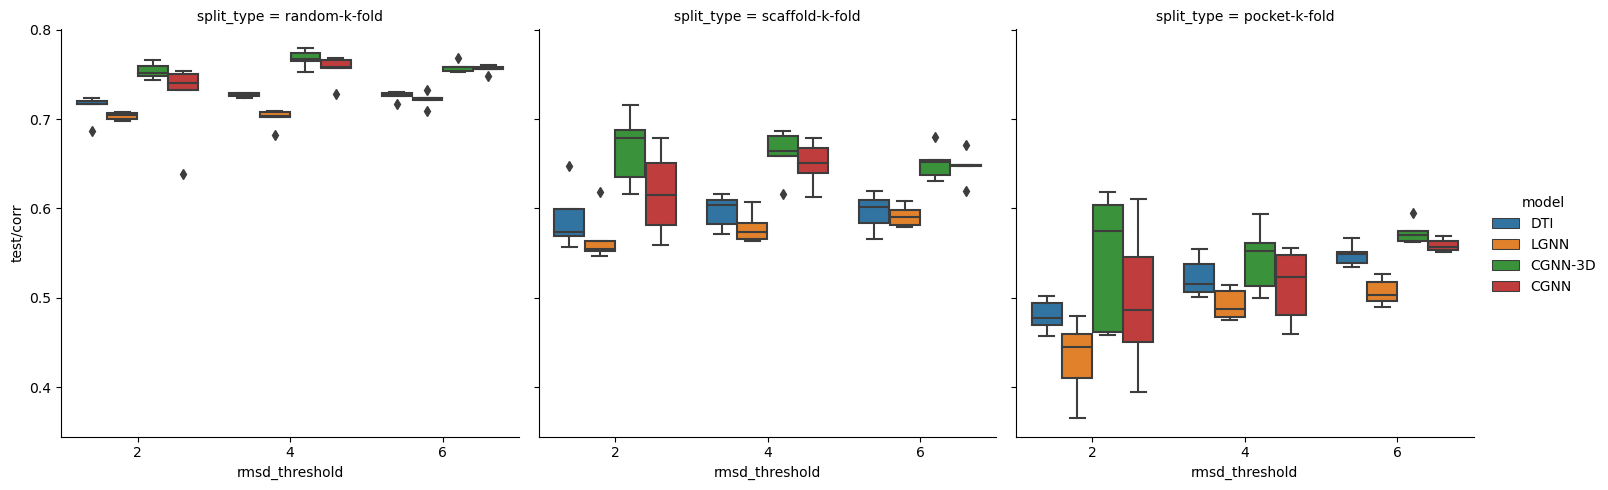

In [7]:
grid = sns.catplot(
    df, x="rmsd_threshold", y="test/corr", hue="model", kind="box",
    col="split_type",sharey=True,
    col_order=["random-k-fold", "scaffold-k-fold", "pocket-k-fold"]
)

In [8]:
df_table = (
    df[["model", "split_type", "rmsd_threshold", "test/mae", "test/corr"]]
    .groupby(["rmsd_threshold", "split_type", "model"])
    .agg(["mean", "std"])
)

In [9]:
df_table

test/mae           test/corr          
                                            mean       std      mean       std
rmsd_threshold split_type      model                                          
2              pocket-k-fold   CGNN     0.858327  0.034301  0.497612  0.083510
                               CGNN-3D  0.799538  0.037316  0.543489  0.077578
                               DTI      0.831429  0.024275  0.480488  0.018217
                               LGNN     0.882478  0.027386  0.432315  0.045078
               random-k-fold   CGNN     0.649105  0.063790  0.723181  0.047916
                               CGNN-3D  0.607028  0.012579  0.753569  0.009123
                               DTI      0.647725  0.012642  0.712910  0.014647
                               LGNN     0.659560  0.007182  0.703192  0.004465
               scaffold-k-fold CGNN     0.759886  0.021112  0.617089  0.048614
                               CGNN-3D  0.707914  0.026209  0.666550  0.040250
                               DTI      0.759351  0.018659  0.589293  0.035893
                               LGNN     0.785194  0.015601  0.567209  0.029030
4              pocket-k-fold   CGNN     0.854433  0.038336  0.513468  0.041890
                               CGNN-3D  0.827691  0.038801  0.544419  0.037727
                               DTI      0.843302  0.019436  0.523092  0.022468
                               LGNN     0.866758  0.032705  0.492805  0.017536
               random-k-fold   CGNN     0.617487  0.018625  0.755240  0.016060
                               CGNN-3D  0.597012  0.014521  0.767820  0.009971
                               DTI      0.651538  0.005148  0.727139  0.002598
                               LGNN     0.679792  0.008620  0.700956  0.011103
               scaffold-k-fold CGNN     0.747178  0.020899  0.650103  0.025468
                               CGNN-3D  0.731163  0.013407  0.661393  0.027681
                               DTI      0.780937  0.010032  0.596840  0.018726
                               LGNN     0.799063  0.017481  0.578977  0.017881
6              pocket-k-fold   CGNN     0.858661  0.007921  0.558950  0.007413
                               CGNN-3D  0.850975  0.009655  0.573171  0.012896
                               DTI      0.868316  0.014812  0.548346  0.012595
                               LGNN     0.900820  0.019576  0.506731  0.014927
               random-k-fold   CGNN     0.655080  0.008883  0.755896  0.004657
                               CGNN-3D  0.644357  0.006143  0.757973  0.006182
                               DTI      0.687639  0.003382  0.726096  0.005212
                               LGNN     0.689591  0.002621  0.721727  0.008249
               scaffold-k-fold CGNN     0.787871  0.004734  0.647143  0.018357
                               CGNN-3D  0.781251  0.010970  0.650741  0.019096
                               DTI      0.823327  0.012385  0.595981  0.021383
                               LGNN     0.830759  0.013489  0.591593  0.011968

## Delta vs. RMSD

In [10]:
df["model"].unique()

array(['DTI', 'LGNN', 'CGNN-3D', 'CGNN'], dtype=object)

In [11]:
data = df.query("model in ('CGNN-3D', 'CGNN')")
print(data.shape)
data.head()

(90, 7)


,run,split_type,split_fold,rmsd_threshold,test/corr,test/mae,model
90,rare-totem-918(1ef7s9zx),scaffold-k-fold,2,4,0.663782,0.739920,CGNN-3D
91,eternal-surf-917(2kynu36x),pocket-k-fold,3,6,0.551651,0.849038,CGNN
92,dandy-valley-916(1aj2r5n1),random-k-fold,3,6,0.748426,0.670315,CGNN
93,flowing-music-915(axrqzxgq),random-k-fold,4,6,0.768045,0.638244,CGNN-3D
94,kind-glade-914(2wxof48f),random-k-fold,3,4,0.779642,0.584931,CGNN-3D


In [14]:
def get_preds(split):
    _data = data.query(f"split_type == '{split}'")
    dfs = []
    for _, row in _data.iterrows():
        run_info = row.run
        predictions = run_info.retrieve_predictions()
        predictions["model"] = row.model
        dfs.append(predictions)
    return pd.concat(dfs, axis=0)

In [15]:
preds = get_preds("scaffold-k-fold")

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downlo

In [16]:
preds.head()

,pred,ident,model
0,8.124529,15619235,CGNN-3D
1,6.700615,5249328,CGNN-3D
2,8.080806,22852732,CGNN-3D
3,7.426722,6183695,CGNN-3D
4,7.447011,19040616,CGNN-3D


In [17]:
from kinodata.data.dataset import KinodataDocked

In [18]:
dataset = KinodataDocked()

In [19]:
data_list = [data for data in dataset]

In [20]:
kino_main_data = {
    "rmsd": [data.predicted_rmsd.item() for data in data_list],
    "ident": [int(data.ident) for data in data_list],
    "target": [data.y.item() for data in data_list]
}

In [21]:
kino_main_data = pd.DataFrame(kino_main_data)
kino_main_data.ident

0            32336
1            32770
2            33033
3            33375
4            34276
            ...   
123636    23347579
123637    23347581
123638    23347583
123639    23347585
123640    23347587
Name: ident, Length: 123641, dtype: int64

In [22]:
preds = pd.merge(
    preds, kino_main_data,
    how="left",
    on="ident"
)

In [23]:
preds = preds.dropna()
preds = preds[preds["rmsd"] < 20]
preds = preds[preds["rmsd"] > 0]

In [24]:
preds["error"] = (preds["target"] - preds["pred"]).abs()

In [25]:
import seaborn as sns
import numpy as np

In [33]:
preds_3d = preds.query("model == 'CGNN-3D'")
preds_no3d = preds.query("model == 'CGNN'")
preds_3d.shape, preds_no3d.shape

((79473, 6), (79473, 6))

In [34]:
preds_rearranged = pd.merge(
    preds_3d, preds_no3d, how="inner", on="ident"
)

In [35]:
preds_rearranged.head()

,pred_x,ident,model_x,rmsd_x,target_x,error_x,pred_y,model_y,rmsd_y,target_y,error_y
0,8.124529,15619235,CGNN-3D,0.536278,6.460924,1.663605,7.130475,CGNN,0.536278,6.460924,0.669550
1,8.124529,15619235,CGNN-3D,0.536278,6.460924,1.663605,6.725211,CGNN,0.536278,6.460924,0.264287
2,7.384974,15619235,CGNN-3D,0.536278,6.460924,0.924050,7.130475,CGNN,0.536278,6.460924,0.669550
3,7.384974,15619235,CGNN-3D,0.536278,6.460924,0.924050,6.725211,CGNN,0.536278,6.460924,0.264287
4,6.700615,5249328,CGNN-3D,2.052248,6.455932,0.244683,5.482995,CGNN,2.052248,6.455932,0.972938


In [36]:
preds_rearranged.head()
improvement = (preds_rearranged["error_x"] / preds_rearranged["error_y"]) - 1
preds_rearranged["improvement"] = improvement

In [37]:
preds_rearranged["improvement"].describe()

count    181089.000000
mean          5.810148
std         109.337022
min          -0.999973
25%          -0.498108
50%          -0.026079
75%           0.914001
max       13093.675000
Name: improvement, dtype: float64

In [38]:
q = preds_rearranged["improvement"].quantile(0.99)

In [39]:
preds_rearranged = preds_rearranged.query(f"improvement <= {q}")

<AxesSubplot: xlabel='rmsd_x', ylabel='improvement'>

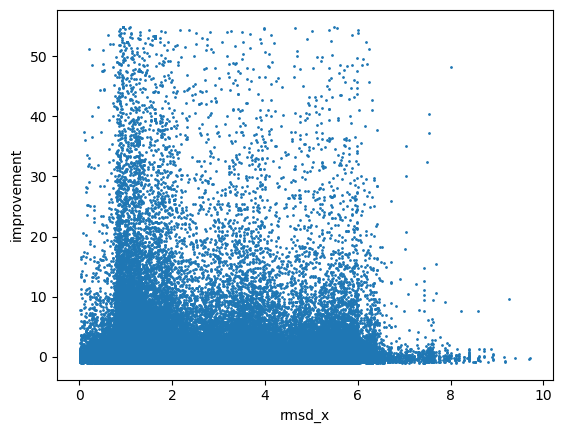

In [41]:
preds_rearranged.plot.scatter(
    x="rmsd_x",
    y="improvement",
    s=1
)